Summary
There are 2 main energy prices: Day Ahead (DA) and Real Time (RT). Day Ahead prices are predicted and broadcast by the Energy Exchange while Real Time prices are decided upon the immediate prevailing market conditions ie Real Time.

LSTM (long short term memory) network is a recurrent neural network that attempts to model time or sequence dependent behaviour – such as stock prices, electricity demand etc. This is performed by feeding back the output of a neural network layer at time t to the input of the same network layer at time t + 1. Therefore this model suited really well for this task of predicting Real Time energy prices. This model is not a fire and forget model and has been very difficult to implement especially given its shape shifting between 2 and 3 dimensional arrays.

The historical data for this model was collected from the Energy and Electricity transmission exchanges. Only 4 of the 8 years of historical data was used due to limitation in computing power. This modeling process is highly tedious and cumbersome and separate models would be used to compute various components of the energy prices such as congestion and demands in order to trade.

In [1]:
# How to make the actual predictions
# Use Dictionary comprehension to connect node label encoders to the node name (ie labels)
# Understand the series_to_supervised function
# WILL NEED TO RUN SEPARATE MODELS TO DETERMINE RT_MCC AND RT_MLC

import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot #as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy.random import seed

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Big figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

seed(1)
from tensorflow import set_random_seed
set_random_seed(42)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Series_to_supervised() Function
1. The shift() function creates new framings of time series problems for the desired input length and output sequences to explore different framings of the time series  with machine learning algorithms to get better performing models.

2. It takes both univariate or multivariate time series and frames it as a supervised learning dataset.

3. Arguments:

    a. data: Sequence of observations as a list or 2D NumPy array. Mandatory.
    
    b. n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
    
    c. n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
    
    d. dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.
    
4. The function returns a single value Pandas DataFrame of series framed for supervised learning.

5. The new dataset is constructed as a DataFrame, and has each column named by variable number and time step. This allows you to design a variety of different time step sequence type forecasting problems from a given univariate or multivariate time series.

6. Once the DataFrame is returned, you can decide how to split the rows of the returned DataFrame into X and y components for supervised learning any way you wish.

7. The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 as X and t as y.

In [2]:
# Will not be connecting directly to sql server since it will be run over and over again and it takes a while.
# Will use CSV instead.
# import pyodbc 
# import getpass
# server = 'ENERGY\POWERTRADING' 
# database = 'Energy_Capstone' 
# username = 'sa' 
# password = getpass.getpass()
# cnxn = pyodbc.connect('DRIVER={ODBC Driver 11 for SQL Server}; SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
# # cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
# cursor = cnxn.cursor()
# #Sample select query
# cursor.execute("SELECT top 10 * from v_DA_vs_RT;") 
# row = cursor.fetchone() 
# while row: 
#     print (row[0] )
#     row = cursor.fetchone()

In [5]:
# load dataset
# dataset = read_csv('ALTEData.csv', header=0, index_col=0)
dataset = read_csv('ALTEDataPredict_RT.csv', header=0, index_col=0)
dataset.drop(['Region'], axis=1,inplace=True)
# dataset.set_index('TradeDate', inplace=True)
dataset.index = dataset.index.to_datetime()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  


In [6]:
def fix_dt(df):
    dateframe = pd.DataFrame({'year': df.index.year.values,
                              'month': df.index.month.values,
                              'day': df.index.day.values,
                              'hour': df['HE'].values - 1})
    df.set_index(pd.to_datetime(dateframe), inplace=True)

In [7]:
fix_dt(dataset)

In [7]:
dataset.drop(columns=['HE'], inplace=True)

In [12]:
dataset.head()

,Node,DA_LMP,DA_MCC,DA_MLC,RT_LMP,RT_MCC,RT_MLC,LMP_DELTA,MCC_DELTA,MLC_DELTA,Planned,Actual,Outage
2014-01-01 00:00:00,ALTE.ALTE,28.58,-3.04,-0.18,23.52,-3.52,-0.14,-5.06,-0.48,0.04,17885,17940,2240
2014-01-01 01:00:00,ALTE.ALTE,27.19,-2.41,-0.50,24.23,-3.14,-0.30,-2.96,-0.73,0.20,17377,17338,2240
2014-01-01 02:00:00,ALTE.ALTE,26.49,-1.77,-0.46,23.44,-2.33,-0.34,-3.05,-0.56,0.12,16966,16919,2240
2014-01-01 03:00:00,ALTE.ALTE,26.31,-1.72,-0.47,22.77,-1.82,-0.37,-3.54,-0.10,0.10,16731,16643,2240
2014-01-01 04:00:00,ALTE.ALTE,25.79,-2.10,-0.46,22.42,-1.48,-0.25,-3.37,0.62,0.21,16602,16503,2240


DATA VISUALIZATION

IndexError: index 8 is out of bounds for axis 1 with size 8

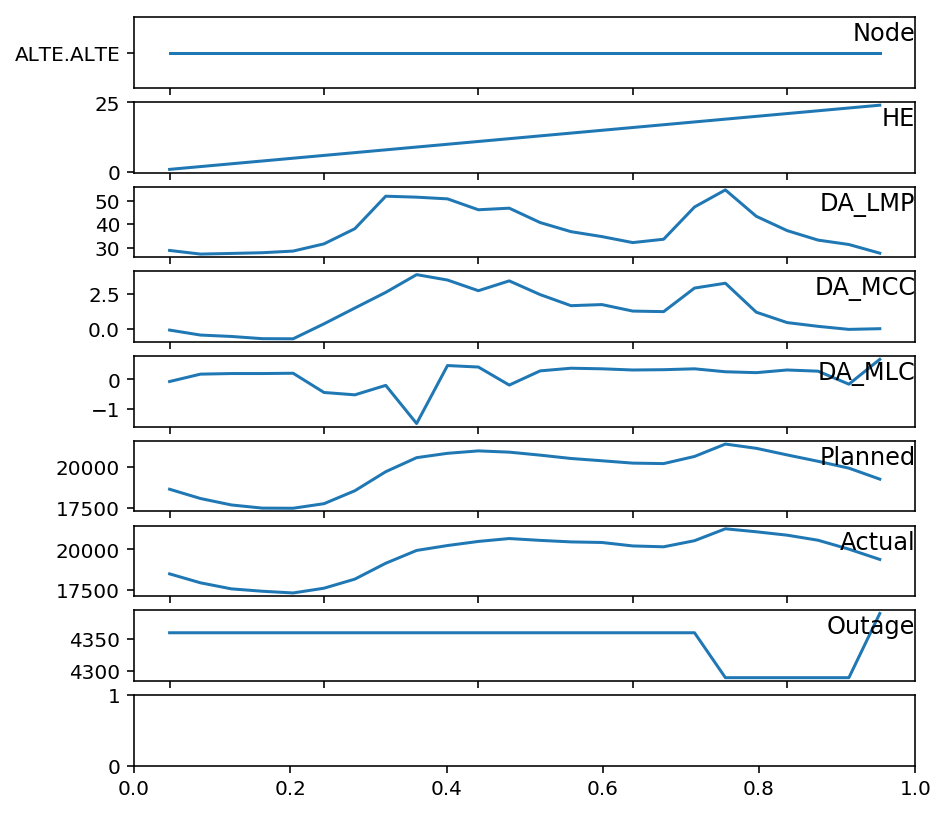

In [8]:
#XXXXXXXXXXXXXXXXX        XXXXXXXXXXXXXXXXXXXXXXXXXXX              XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# Upon initial glance its clear that energy demands are cyclical. But the energy prices are not cyclical. They fluctuate 
# based on power availabiity, Outages and other congestion.
#             XXXXXXXXXXXXXXXXXXXXXX            XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX         XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
i = 1
# plot each column
pyplot.figure(figsize=(7,10))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(dataset.values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

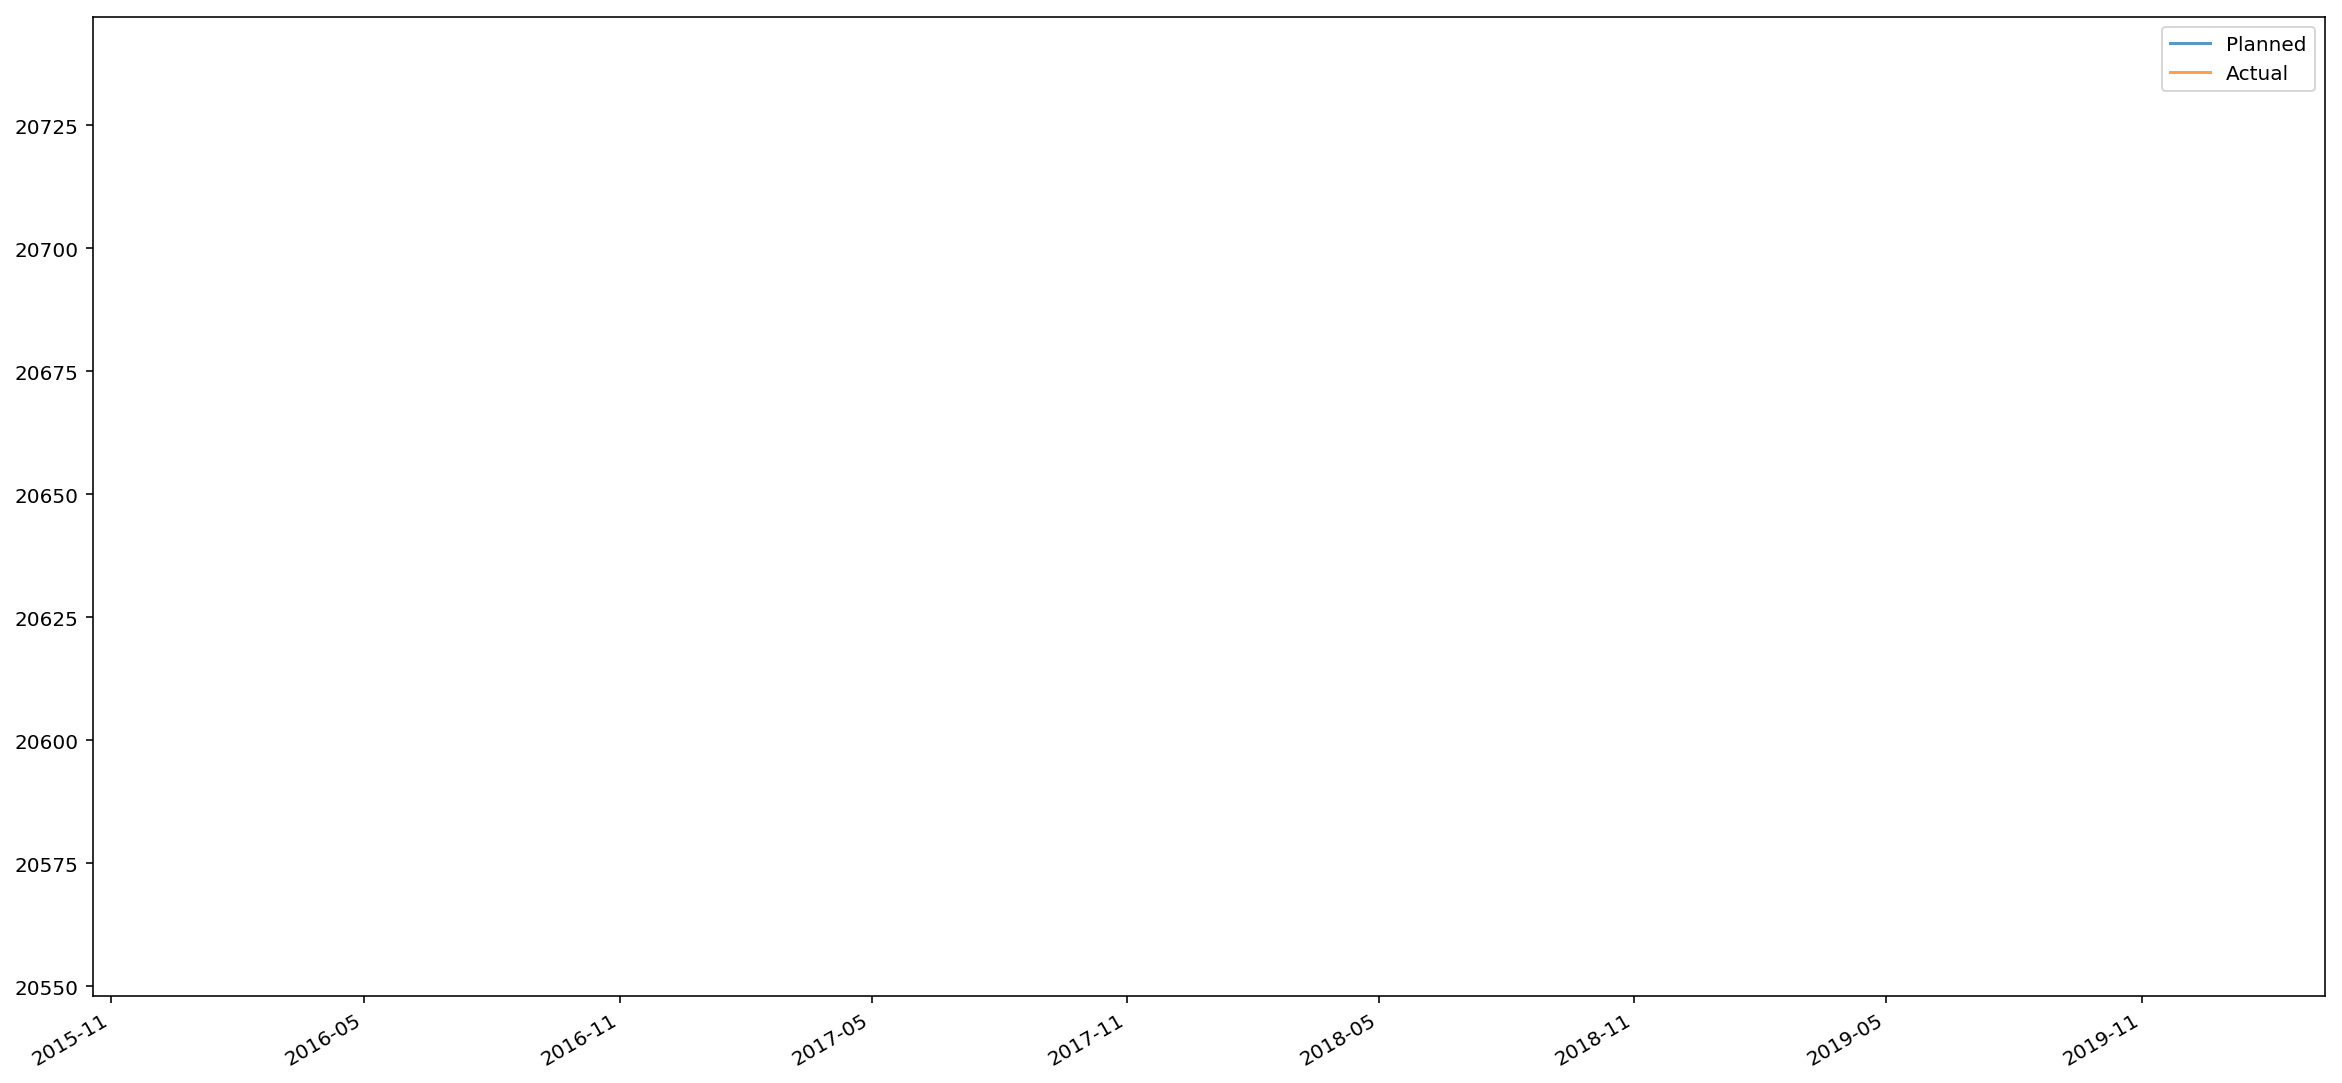

In [9]:
# 1LOAD FORECAST - 4 years
dataset['Planned'][12::24].plot(figsize=(20,10), alpha=.75)
dataset['Actual'][12::24].plot(figsize=(20,10), alpha=.75)

plt.legend();

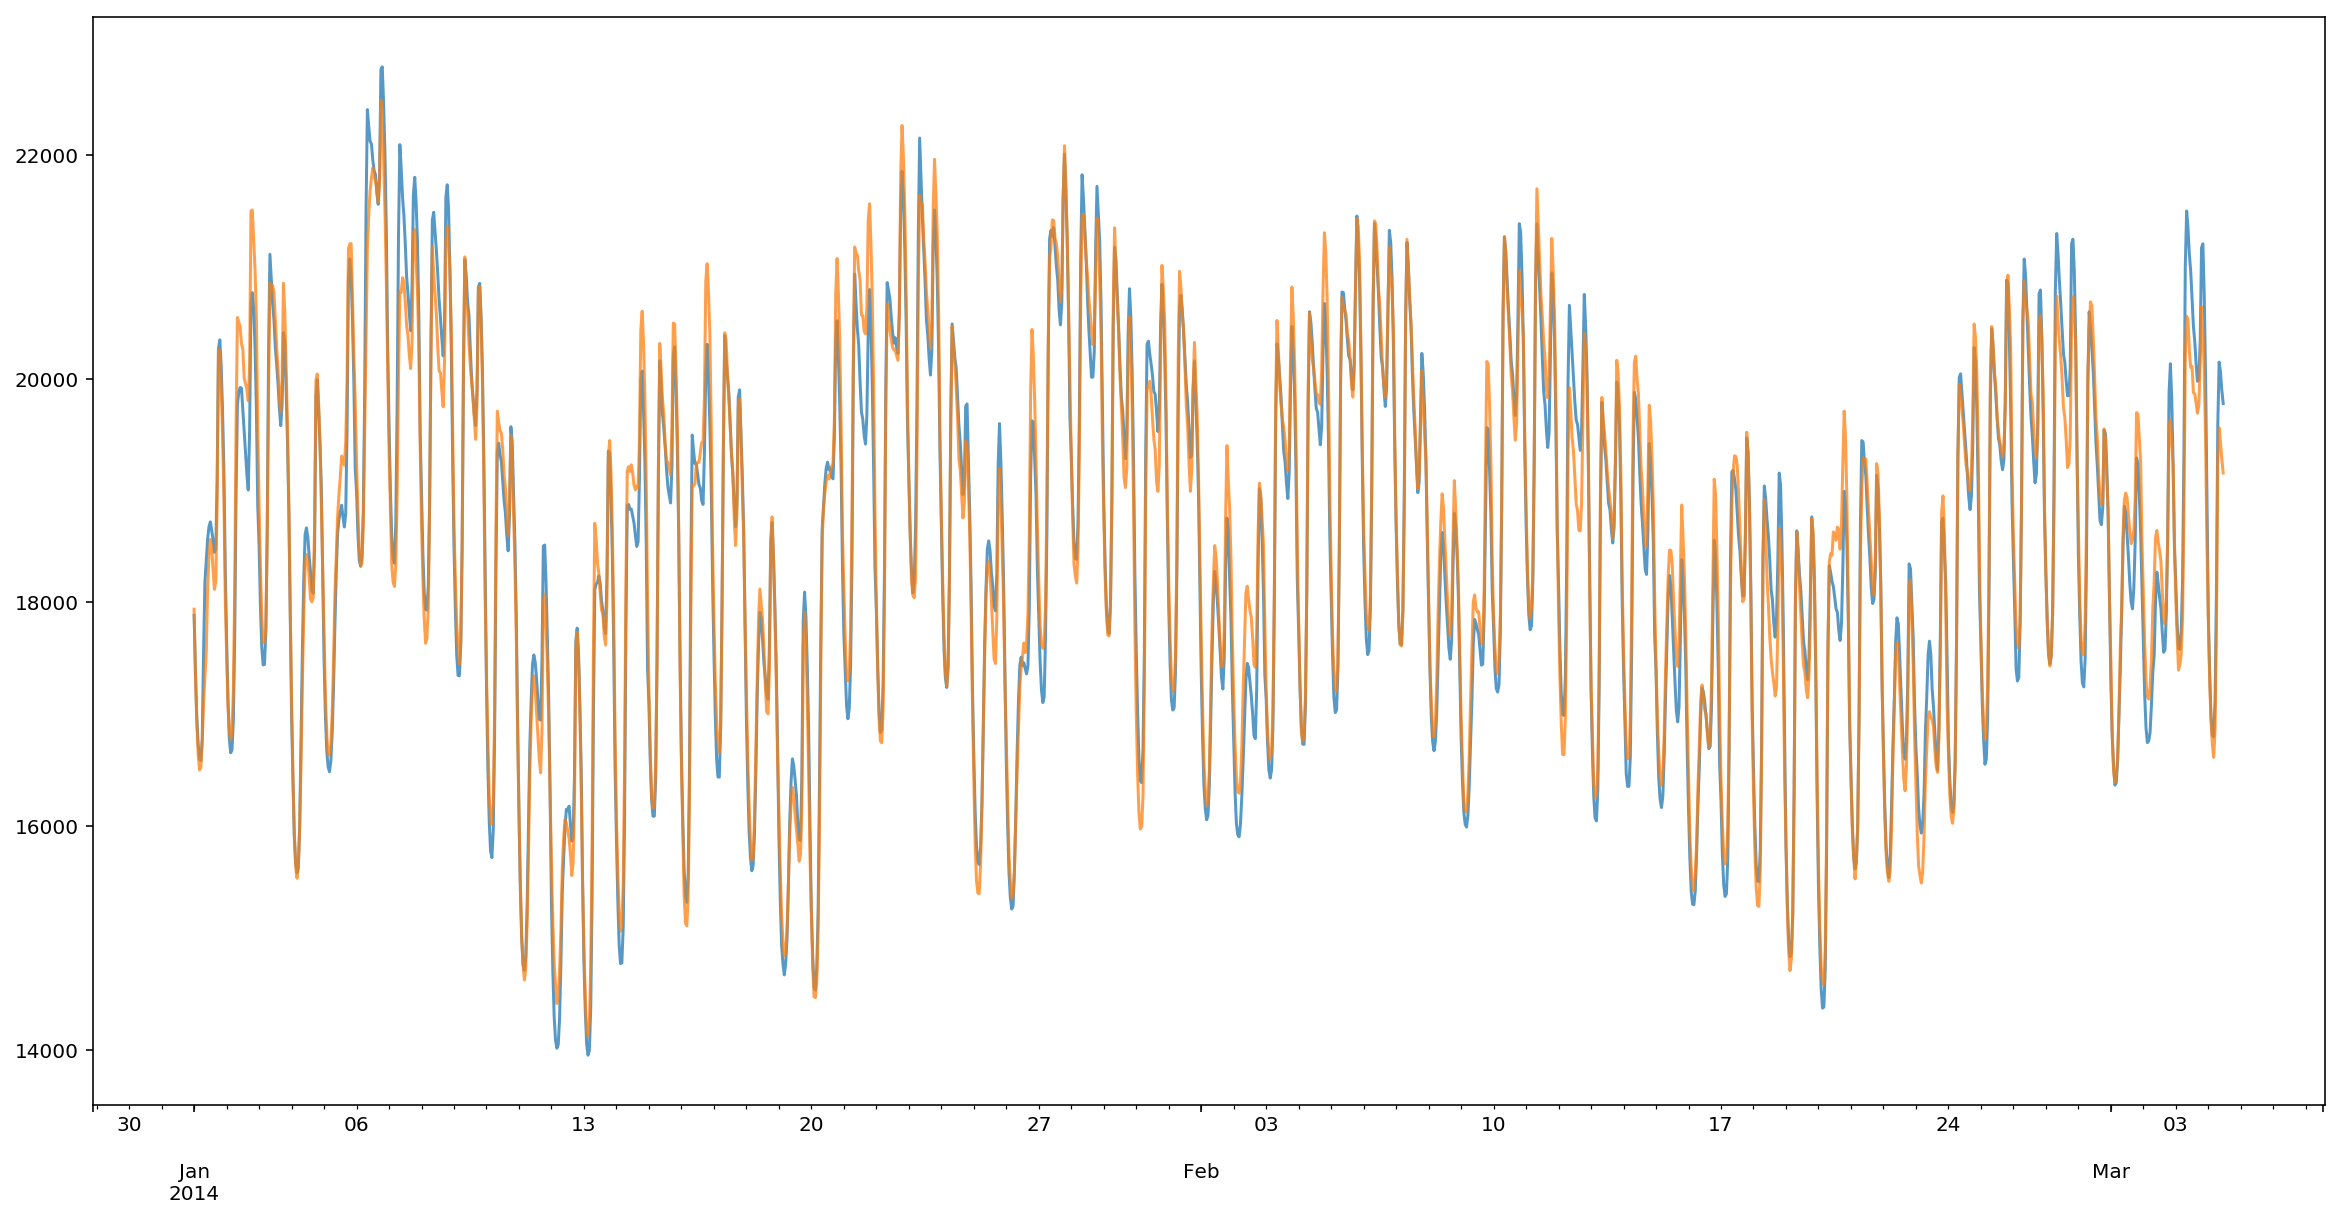

In [47]:
# 2 LOAD FORECAST - 3 month Jan-Feb-Mar
dataset['Planned'][:1500].plot(figsize=(20,10), alpha=.75)
dataset['Actual'][:1500].plot(figsize=(20,10), alpha=.75)
# dataset['Outage'][:1500].plot(figsize=(20,10), alpha=.75)

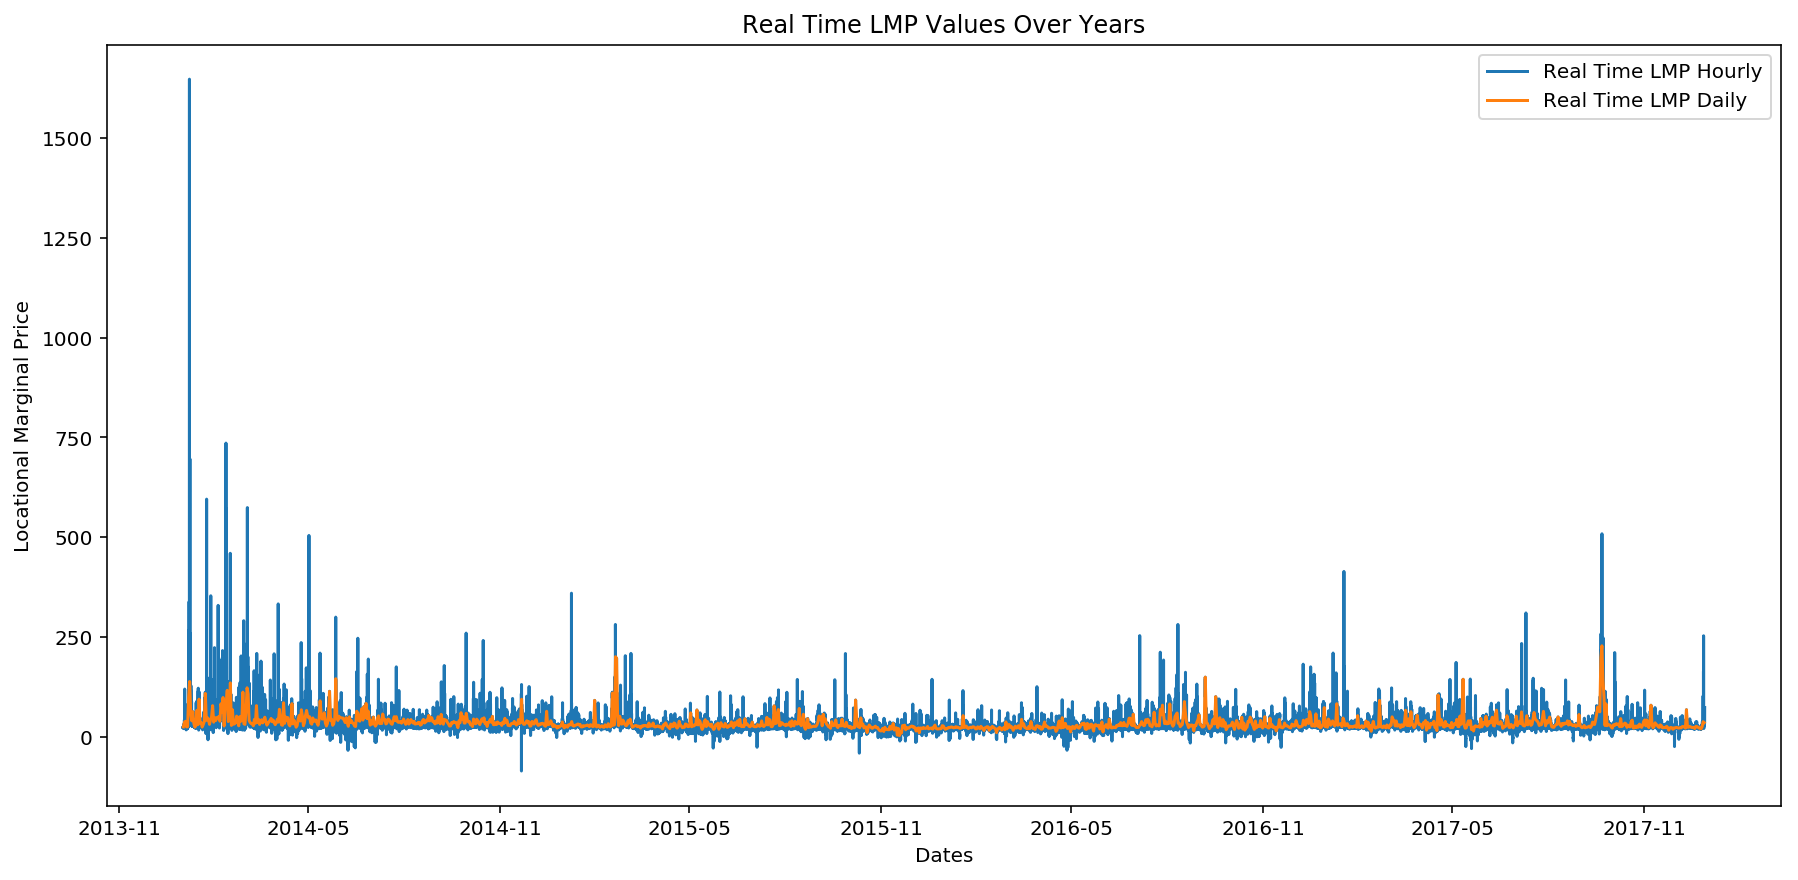

In [33]:
# It shows that RT prices do not follow a certain trend. 4 years
plt.plot(dataset['RT_LMP'], label='Real Time LMP Hourly')
plt.plot(dataset['RT_LMP'][12::24], label='Real Time LMP Daily')
plt.xlabel('Dates')
plt.ylabel('Locational Marginal Price')
plt.title('Real Time LMP Values Over Years')
plt.legend();

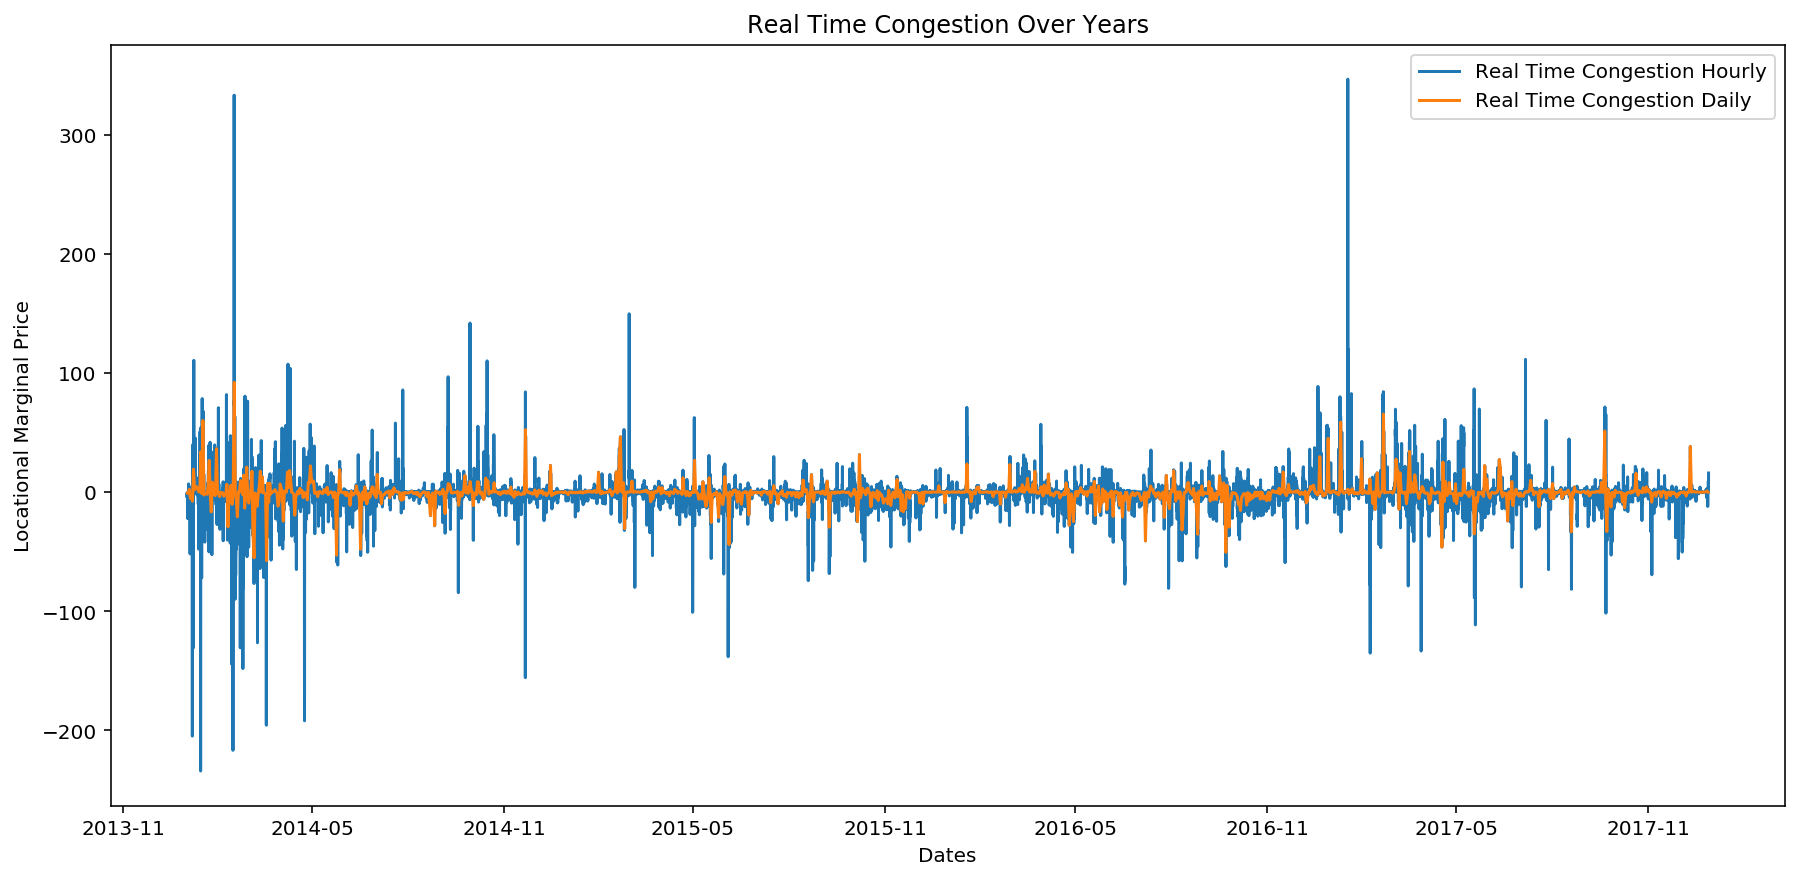

In [49]:
# It shows that Congestion prices do not follow a certain trend over 4 years but it does contribute to changes in RT prices
plt.plot(dataset['RT_MCC'], label='Real Time Congestion Hourly')
plt.plot(dataset['RT_MCC'][12::24], label='Real Time Congestion Daily')
plt.xlabel('Dates')
plt.ylabel('Locational Marginal Price')
plt.title('Real Time Congestion Over Years')
plt.legend();

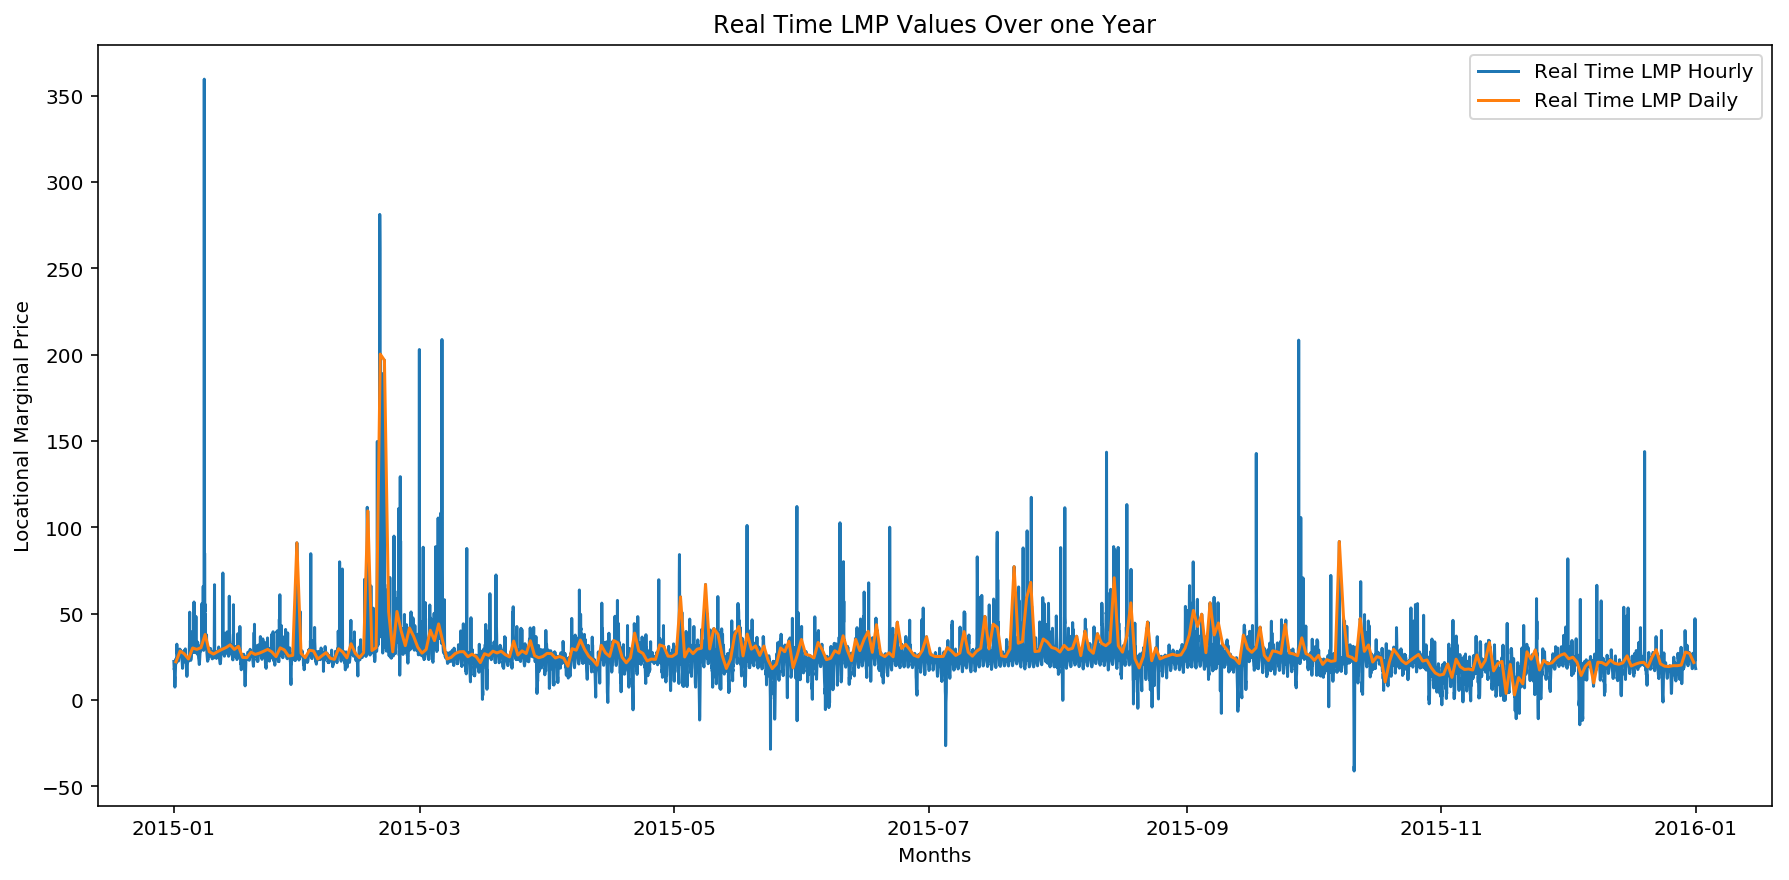

In [34]:
# We can now start to see a weekly behavior in the daily (orange) line.
plt.plot(dataset['RT_LMP']['2015'], label='Real Time LMP Hourly')
plt.plot(dataset['RT_LMP']['2015'][12::24], label='Real Time LMP Daily')
plt.xlabel('Months')
plt.ylabel('Locational Marginal Price')
plt.title('Real Time LMP Values Over one Year')
plt.legend();

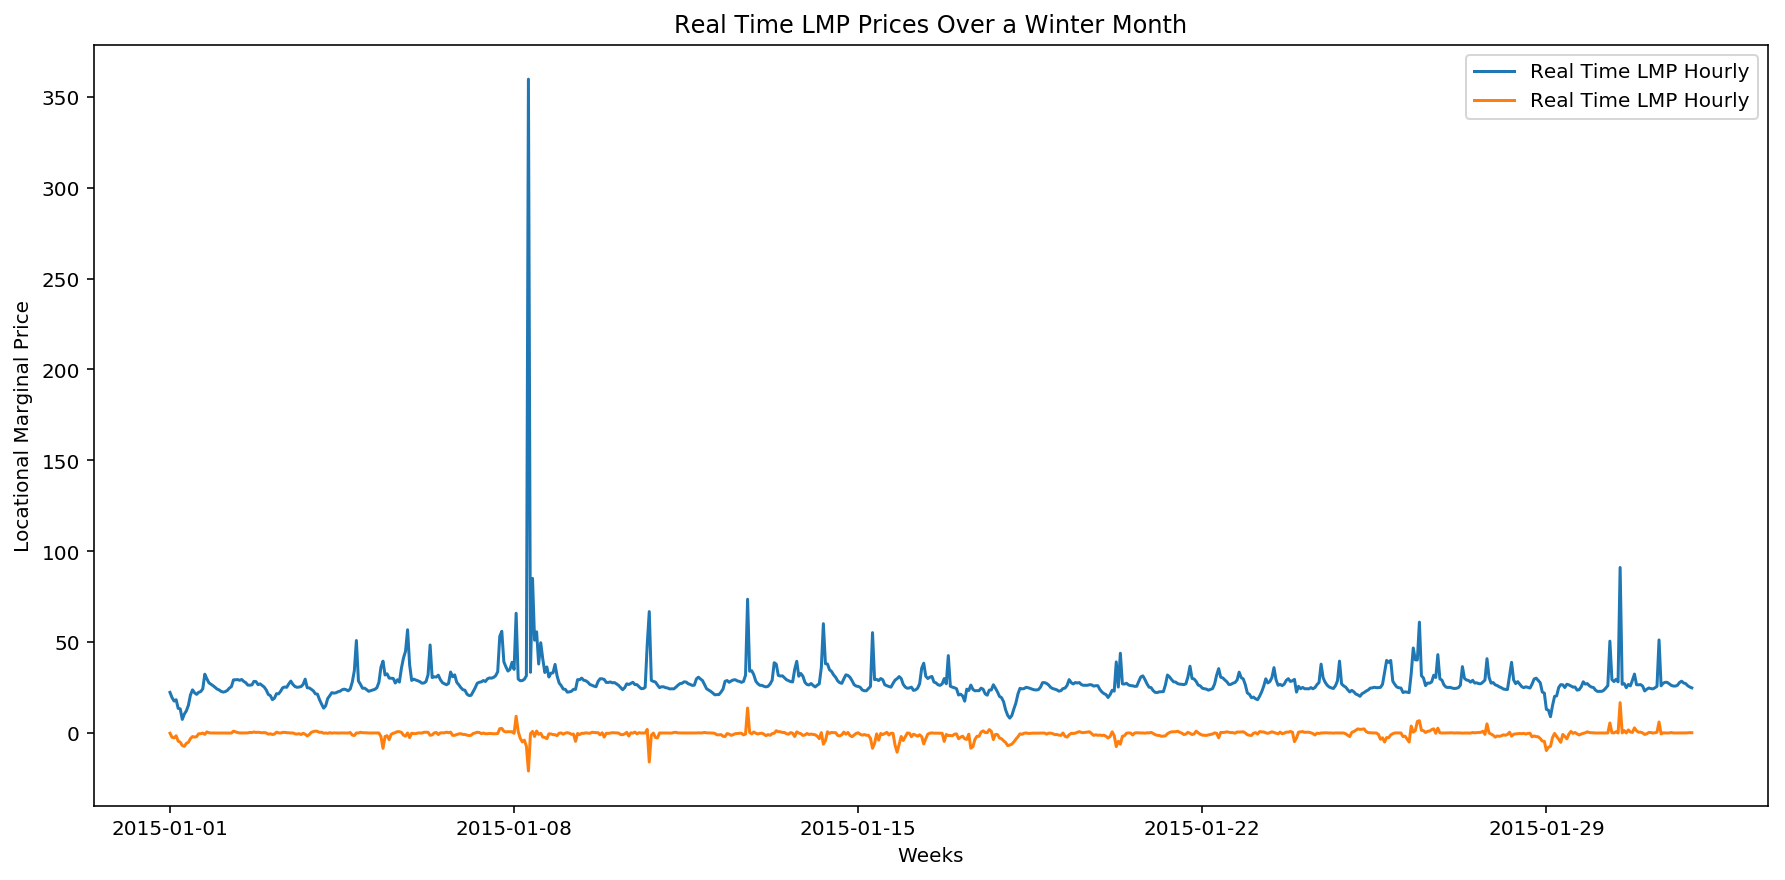

In [51]:
# A new pattern, genearlly consisting of one minor hump followed by a major
# hump and recurring every day, is shown by the hourly (blue) line. There also would seem to be four
# distinct sections that have higher hourly variance seperated by a day or two
# of slightly lower energy costs. Given the time span being examined, it is
# reasonable to infer that it very well could be the weekly trend seen in orange
# just above.
plt.plot(dataset['RT_LMP']['2015-01'], label='Real Time LMP Hourly')
plt.plot(dataset['RT_MCC']['2015-01'], label='Real Time LMP Hourly')
plt.xlabel('Weeks')
plt.ylabel('Locational Marginal Price')
plt.title('Real Time LMP Prices Over a Winter Month')
plt.legend();

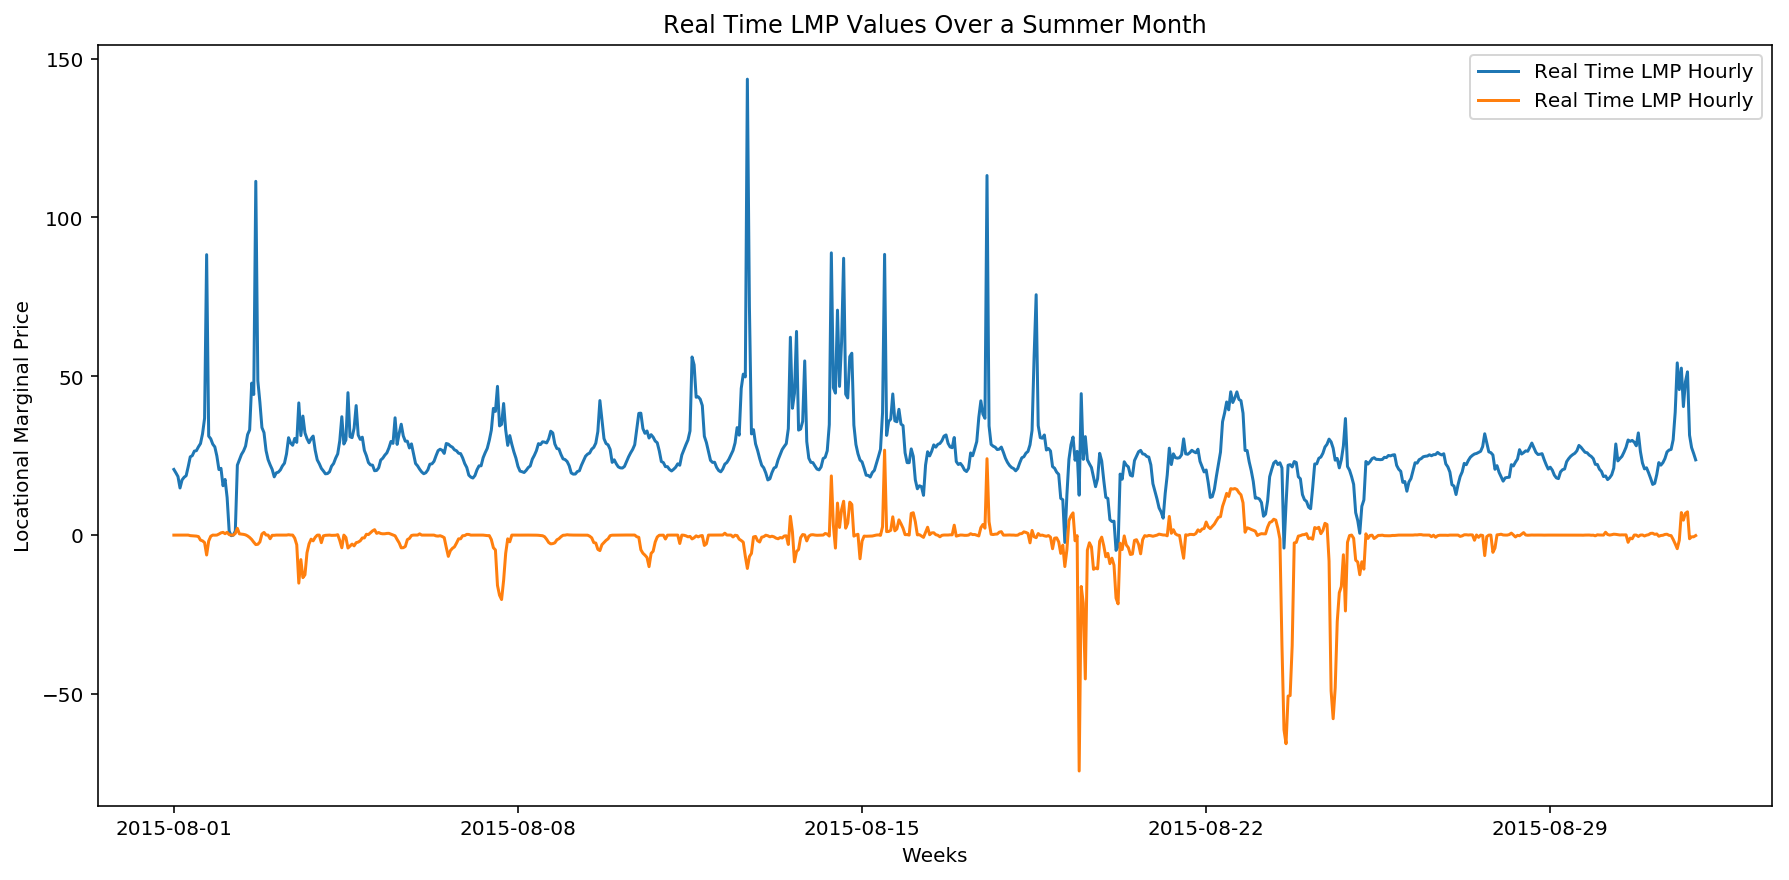

In [52]:
# Higher Eenrgy prices over summer month mainly due to high temps. That's the prices are high but not erratic.
plt.plot(dataset['RT_LMP']['2015-08'], label='Real Time LMP Hourly')
plt.plot(dataset['RT_MCC']['2015-08'], label='Real Time LMP Hourly')
plt.xlabel('Weeks')
plt.ylabel('Locational Marginal Price')
plt.title('Real Time LMP Values Over a Summer Month')
plt.legend();

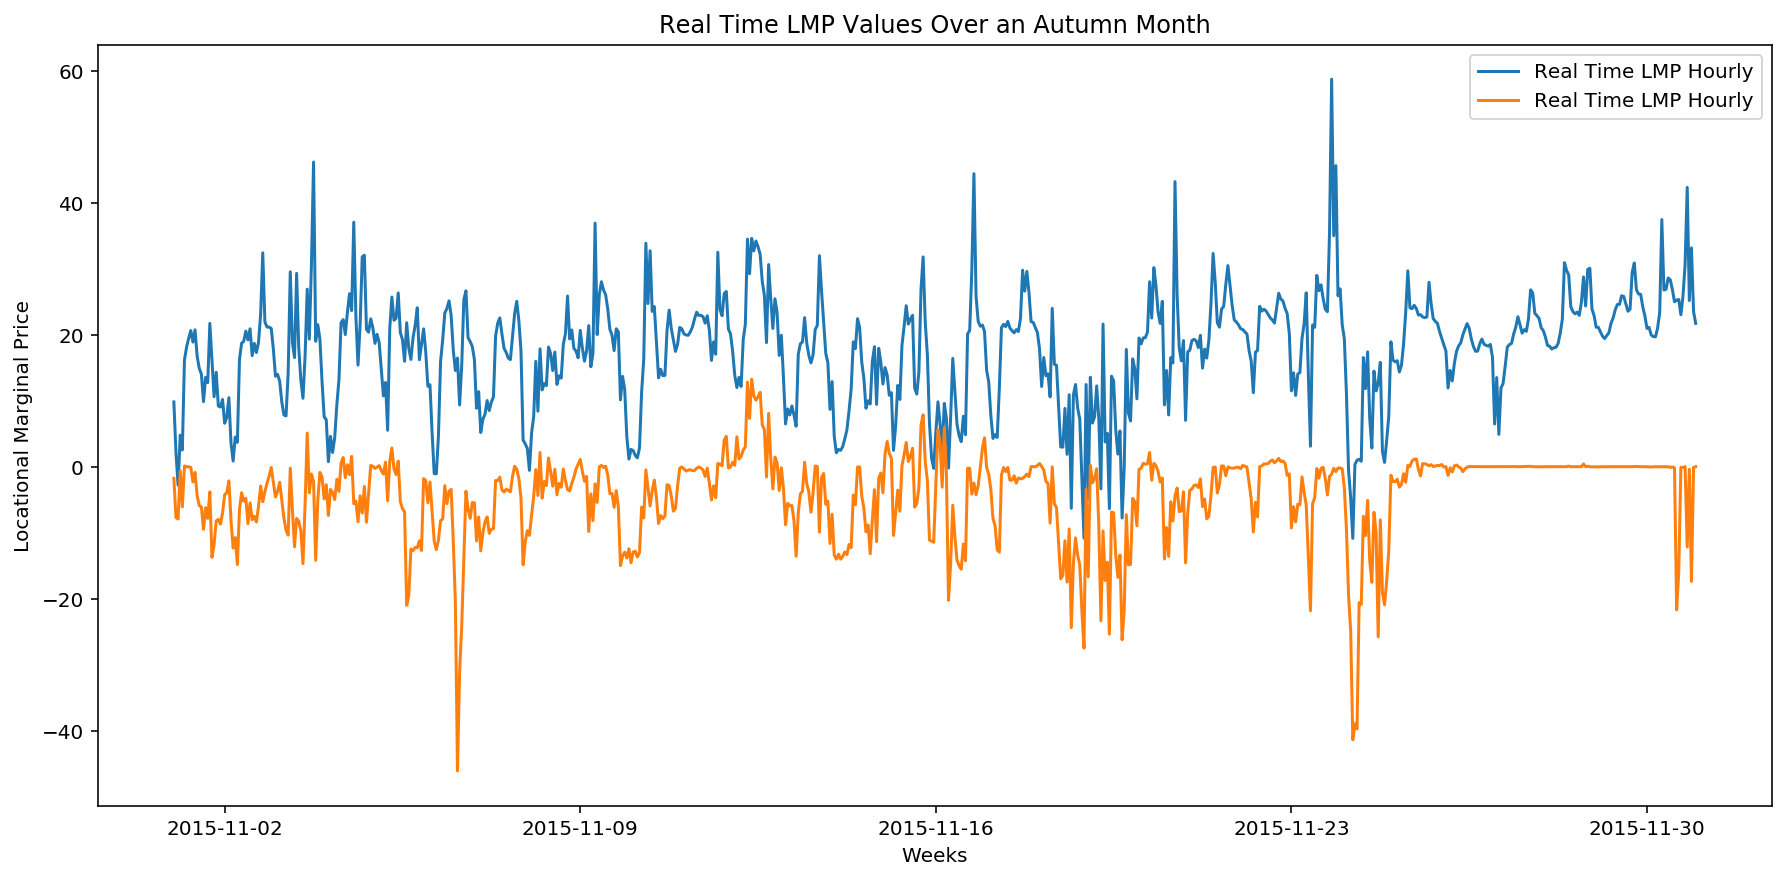

In [50]:
# Higher prices due to outage and not temps. The prices are very erratic
plt.plot(dataset['RT_LMP']['2015-11'], label='Real Time LMP Hourly')
plt.plot(dataset['RT_MCC']['2015-11'], label='Real Time LMP Hourly')
plt.xlabel('Weeks')
plt.ylabel('Locational Marginal Price')
plt.title('Real Time LMP Values Over an Autumn Month')
plt.legend();

SEASONAL DECOMPOSITION

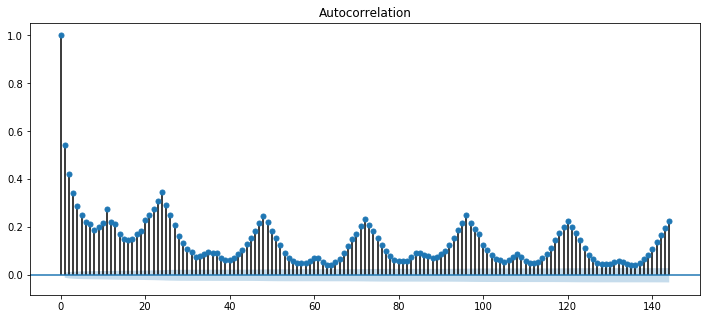

In [12]:
# 3 REAL TIME PRICE AUTOCORRELATION. 144 hours. There is some cyclical behaviour given that prices go up every 12 hours.
# Its very clear that day time real time prices are higher than might time peak. This is month of januray
# These are plots that graphically summarize the strength of a relationship with an observation in a time series with 
# observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult 
# and confusing for beginners to time series forecasting.
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(dataset['RT_LMP'], lags=144, ax=ax)
# plot_acf(dataset['Planned'], lags=144, ax=ax)
plt.show();

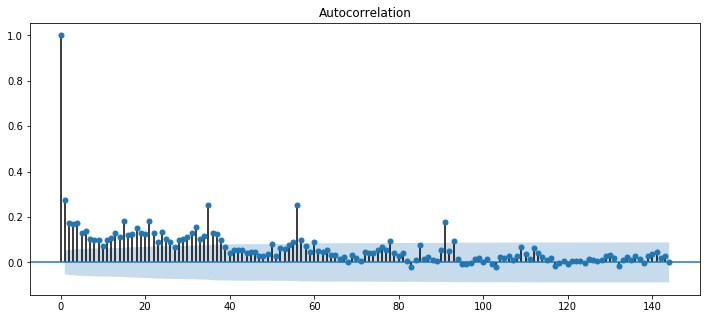

In [12]:
# 4:  Weekday prices. It dies down over the weekend.
fig, ax = plt.subplots(figsize=(12,5))
# plot_acf(dataset['RT_LMP'][::24], lags=208, ax=ax)
plot_acf(dataset['RT_LMP'][::24], lags=144, ax=ax)
plt.show();

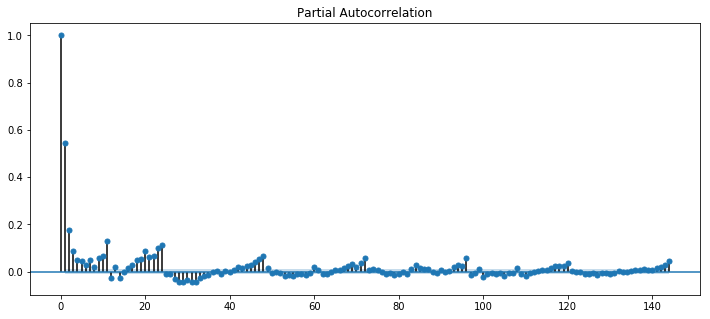

In [13]:
# 5: It is the correlation between two variables under the assumption that we know and take into account the values of some 
# other set of variables.
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(dataset['RT_LMP'], lags=144, ax=ax)
plt.show();

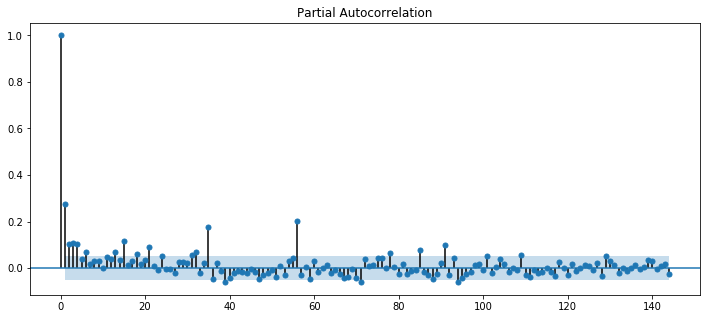

In [14]:
# 6: 
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(dataset['RT_LMP'][::24], lags=144, ax=ax)
plt.show();

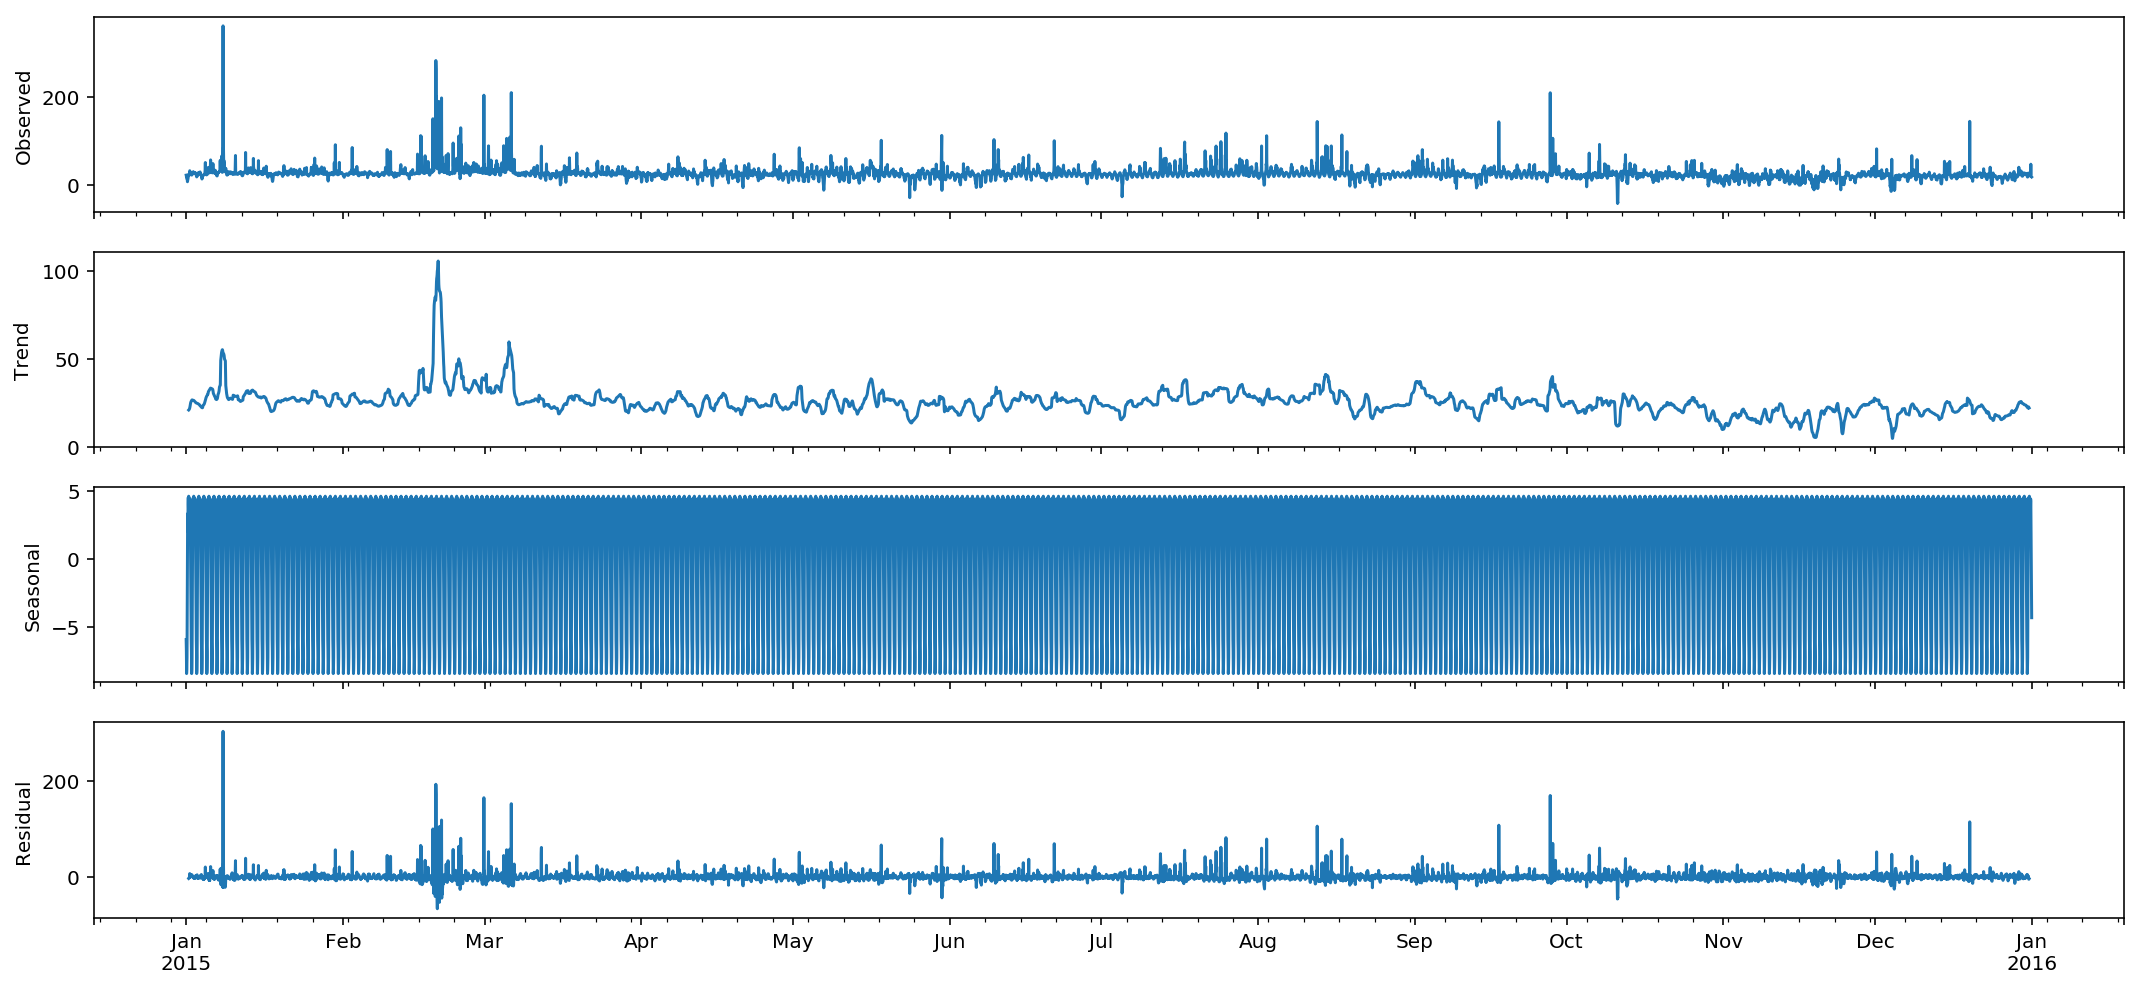

In [35]:
# So far we haven't really seen much indcation of an annual trend, though it
# seems somewhat counter intuitive from what I know of my own power bill
# through the years. In this case either the other two seasonal trends are
# drowning it out or there really isn't much difference in demand through the
# seasons at this node location.
seasonal_decompose(dataset['2015']['RT_LMP']).plot();

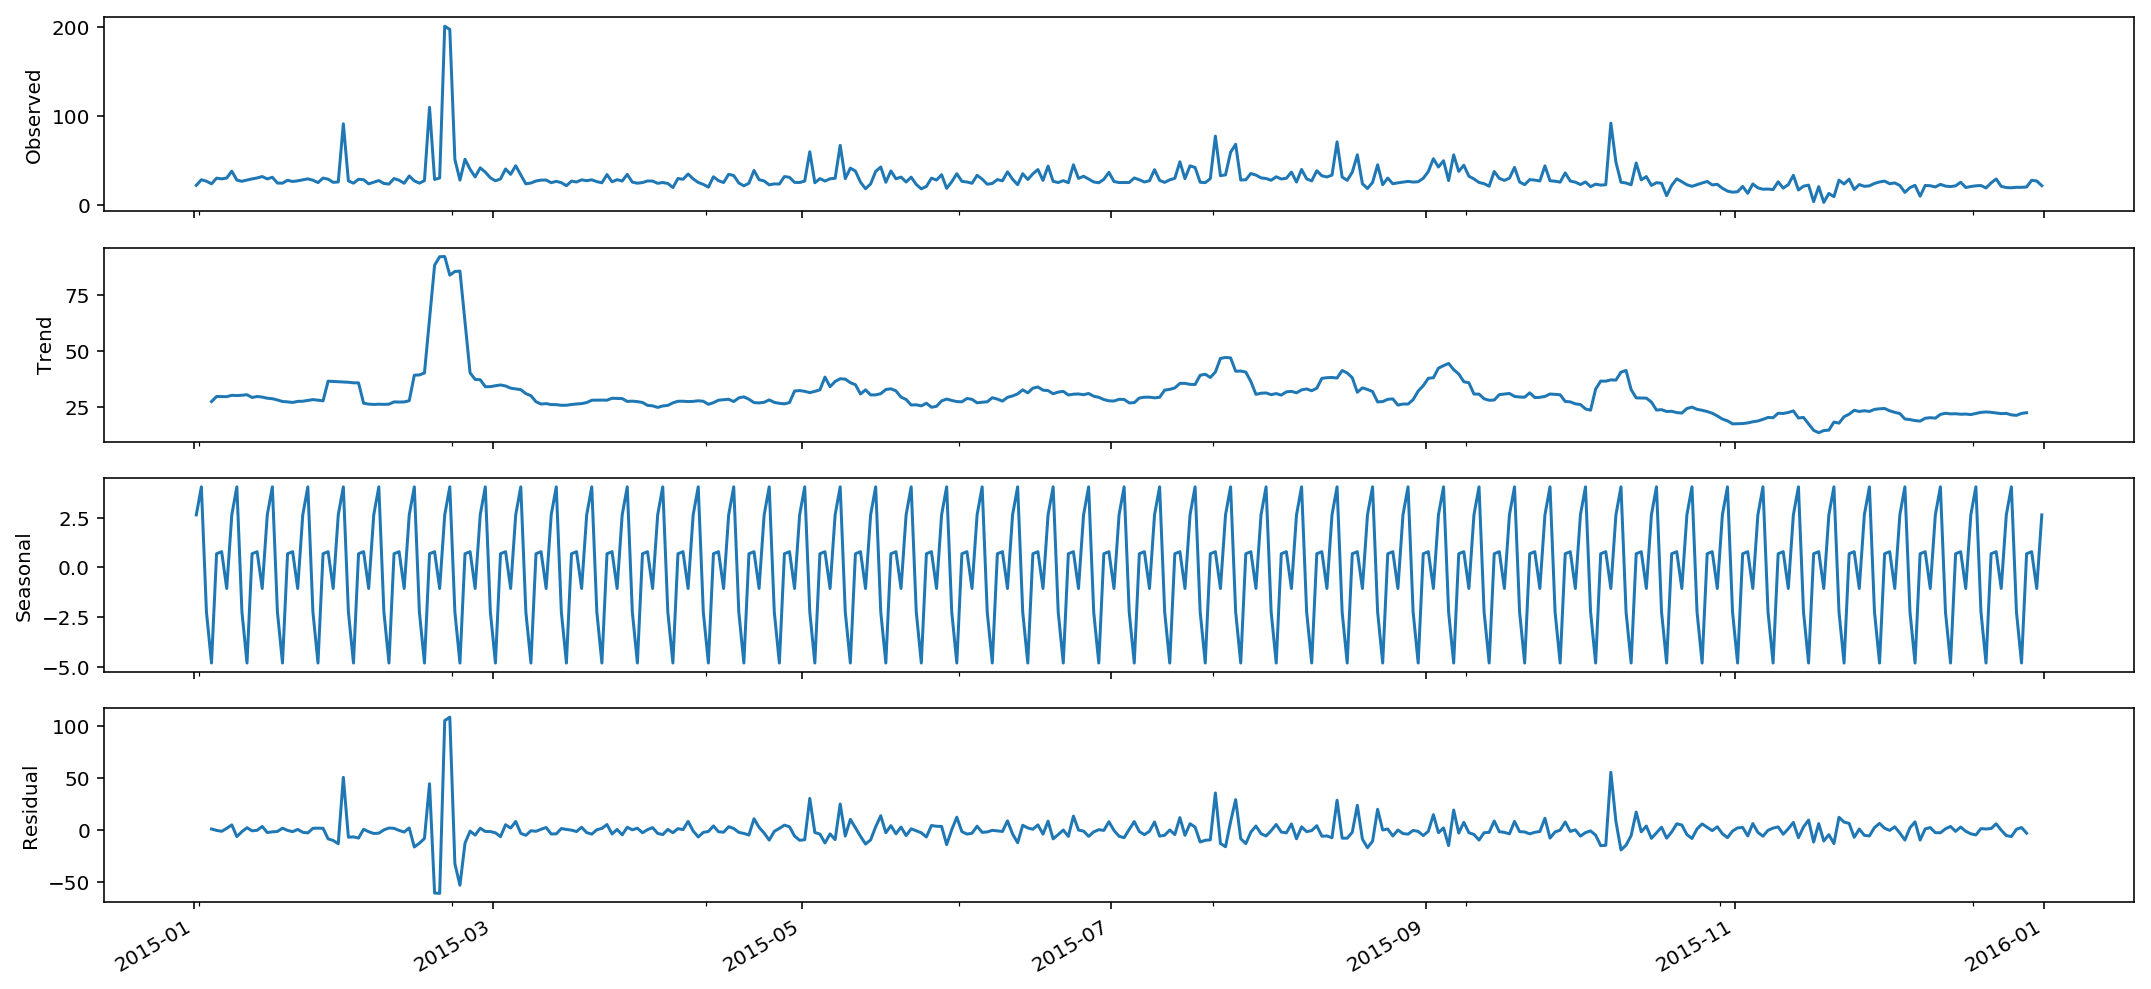

In [29]:
# Sticking to daily values, the seasonal component of the decomposition
# beautifully illustrates the weekly pattern over 1 year
seasonal_decompose(dataset['2015']['RT_LMP'][12::24]).plot();

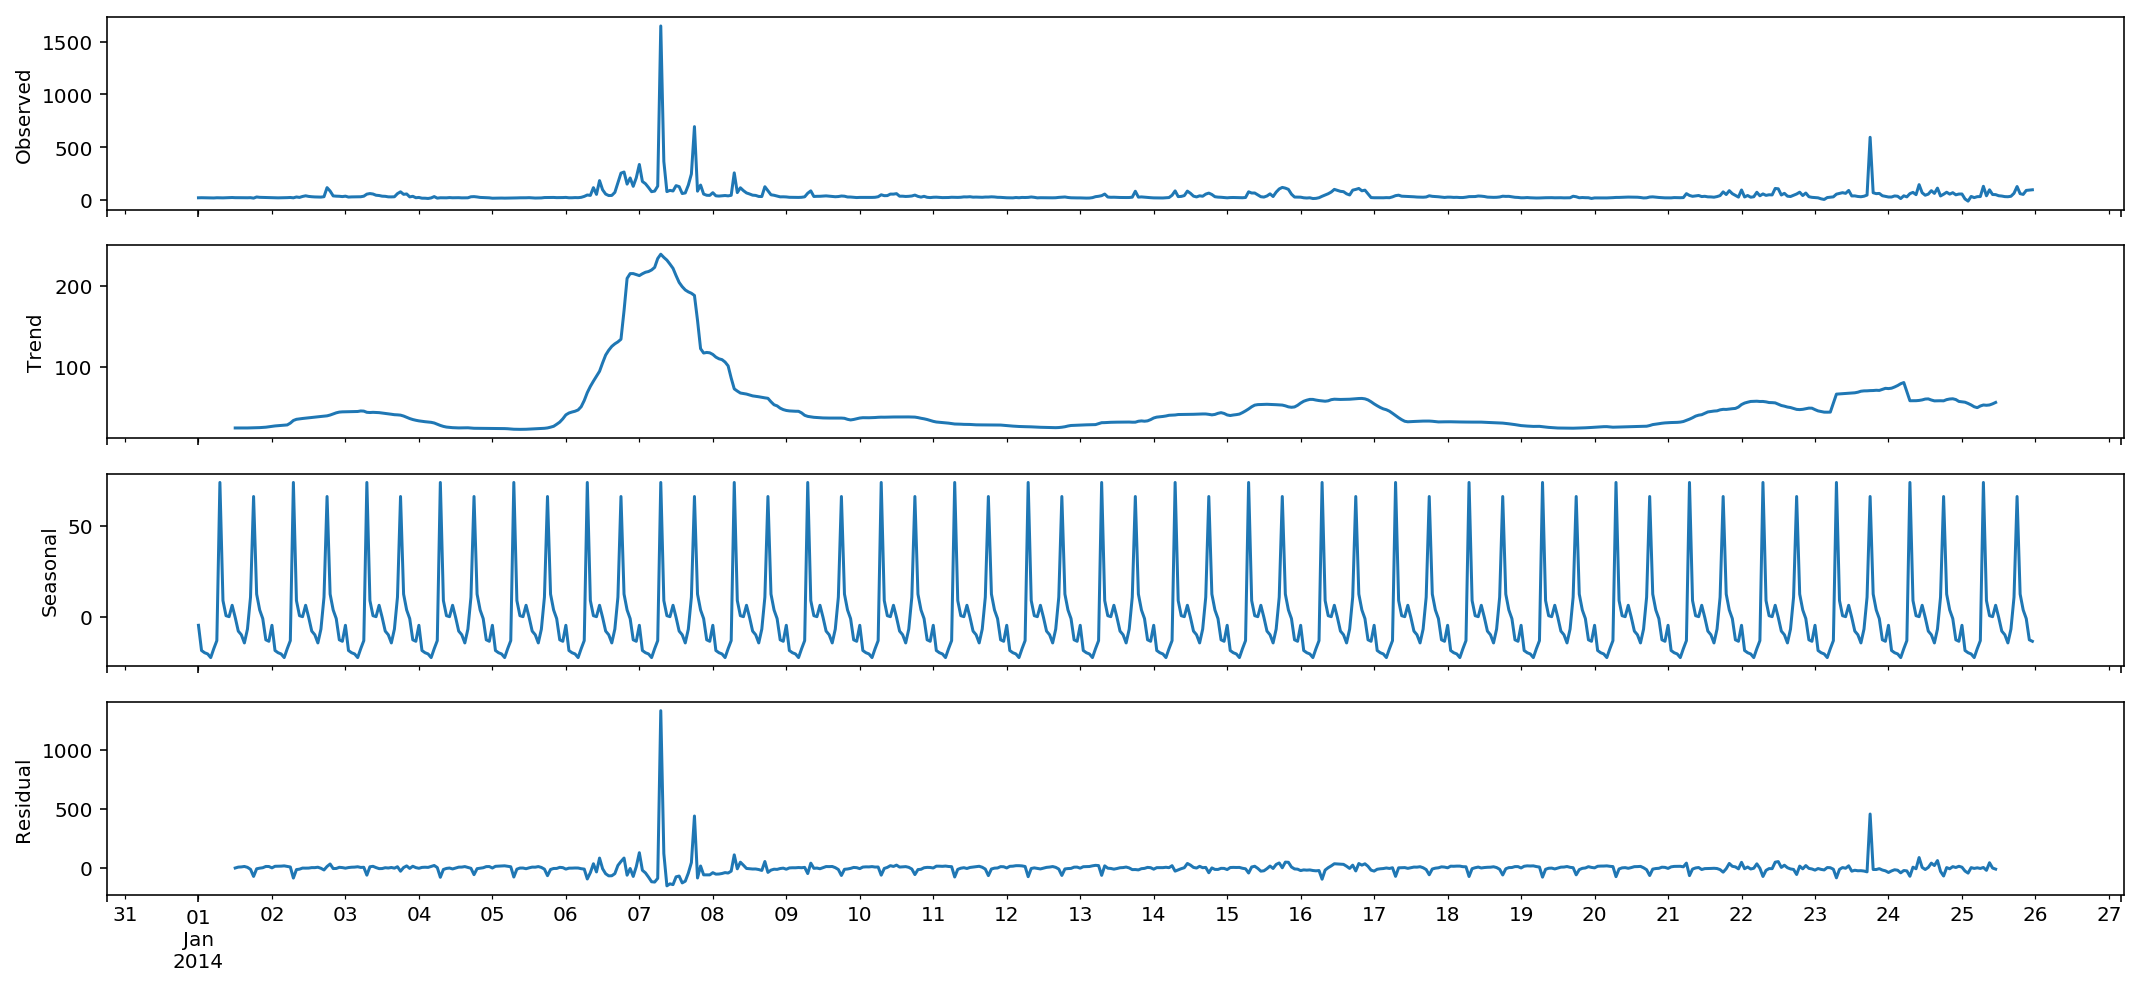

In [31]:
# # 7: # Sticking to daily values, the seasonal component of the decomposition
# beautifully illustrates the weekly pattern over a month
seasonal_decompose(dataset['RT_LMP'][:600:]).plot();

In [17]:
dataset_Plot = dataset.copy()

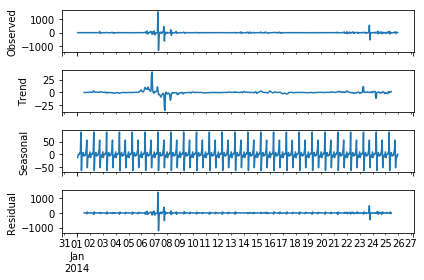

In [18]:
# 8
# dataset['Plannediff'] = dataset['Planned'].diff()
dataset_Plot['RT_LMPDiff'] = dataset['RT_LMP'].diff()
seasonal_decompose(dataset_Plot['RT_LMPDiff'][1:600]).plot();

In [10]:
# 9
dataset_Plot['RT_LMPDiff24'] = dataset['RT_LMP'].diff(24)
seasonal_decompose(dataset_Plot['RT_LMPDiff24'][24:600]).plot();

KeyError: 'RT_LMP'

In [ ]:
# Though it's typically for detrending, it's worth knowing the behavior since
# ARIMA modeling with d=1 is essentially the same as doing ARMA with diff(1)
diff1 = pd.Series(np.diff(df['DA_LMP'], n=1), index=df[1:].index)

In [ ]:
# Unsurprisingly time t and t-24 are most strongly correlated. What is odd is
# the slight bump every 12 hours. Also the prominence of the 15th lag in the pacf.
fig = plt.figure(figsize=(17,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['DA_LMP'], lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['DA_LMP'], lags=40, ax=ax2)
plt.show()

In [ ]:
# Diff(1) - lags 12 and 24 are again the winners. Both correlations once again
# fail to converge in a timely fashion
fig = plt.figure(figsize=(17,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1, lags=40, ax=ax2)
plt.show()

In [ ]:
# Diff(24) - The pacf starts at 0 which I've never seen before. Meanwhile the
# acf fancies itself a self replicating organic nucleotide chain. In such a case
# the autocorrelation value would infact be very close to -1 as it alternates
# each lag. Oddly enough the autocorrelation functions for diff(168) and the
# second order differences very much resembled these charts.
fig = plt.figure(figsize=(17,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff24, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff24, lags=40, ax=ax2)
plt.show()

In [20]:
#Use Dictionary comprehension to connect node label encoders to the node name (ie labels)

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
dataset.dropna(inplace=True)
values = dataset.drop("RT_LMP", axis = 1).values
values_y = dataset["RT_LMP"].values

In [15]:
# integer encode direction
encoder = LabelEncoder()
colArray = [0]
for i in colArray:
#     print(i)
    values[:,i] = encoder.fit_transform(values[:,i])


In [16]:
# ensure all data is float
values = values.astype('float32')
values_y = values_y.astype('float32')

In [17]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# # frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# reframed = series_to_supervised(scaled, 1, 1) # Original
# # drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

In [18]:
values_y = values_y[1:]
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
length  = round((len(values)*.75)) #.75 is the cutoff point of the training set
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
train_X = values[:length, :]
test_X = values[length:, :]
# split into input and outputs
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]
train_y = values_y[:length]
test_y = values_y[length:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26243, 1, 24) (26243,) (8748, 1, 24) (8748,)


In [19]:
# design network -- Original code
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))) #50 is the number of nuerons/nodes
model.add(Dense(1)) #this is the output layer. With LSTM 1 output layer is the norm
model.compile(loss='mae', optimizer='adam')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                15000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit network
# Original batch size was 72 and it converged at 40. Batch size 50 was better and 30 was even better and 20 better yet
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#batch size is super important in neural networks and LSTM in particular. 
# size of the Short term memory is dependent on the Batch size 
# batch size determines how long the path persists before the weights 
# A batch A small batch size of 32 (lets say) will make it more sensitive to changes to that are more approximate in time
# 72 batch size will make it capable of remembering trends that reoccur over longer intervels 
# More stocastic the data higher the batch size 


Train on 26243 samples, validate on 8748 samples
Epoch 1/50
 - 3s - loss: 16.2524 - val_loss: 7.3062
Epoch 2/50
 - 2s - loss: 8.5381 - val_loss: 6.7538
Epoch 3/50
 - 2s - loss: 7.8307 - val_loss: 6.5136
Epoch 4/50
 - 2s - loss: 7.5133 - val_loss: 6.4522
Epoch 5/50
 - 2s - loss: 7.3703 - val_loss: 6.4233
Epoch 6/50
 - 2s - loss: 7.2766 - val_loss: 6.3890
Epoch 7/50
 - 2s - loss: 7.2007 - val_loss: 6.3529
Epoch 8/50
 - 2s - loss: 7.1392 - val_loss: 6.3243
Epoch 9/50
 - 2s - loss: 7.0878 - val_loss: 6.2959
Epoch 10/50
 - 2s - loss: 7.0380 - val_loss: 6.2686
Epoch 11/50
 - 2s - loss: 6.9917 - val_loss: 6.2432
Epoch 12/50
 - 2s - loss: 6.9458 - val_loss: 6.2206
Epoch 13/50
 - 2s - loss: 6.9023 - val_loss: 6.1975
Epoch 14/50
 - 2s - loss: 6.8530 - val_loss: 6.1773
Epoch 15/50
 - 2s - loss: 6.8061 - val_loss: 6.1521
Epoch 16/50
 - 2s - loss: 6.7613 - val_loss: 6.1342
Epoch 17/50
 - 2s - loss: 6.7131 - val_loss: 6.1185
Epoch 18/50
 - 2s - loss: 6.6684 - val_loss: 6.1032
Epoch 19/50
 - 2s - los

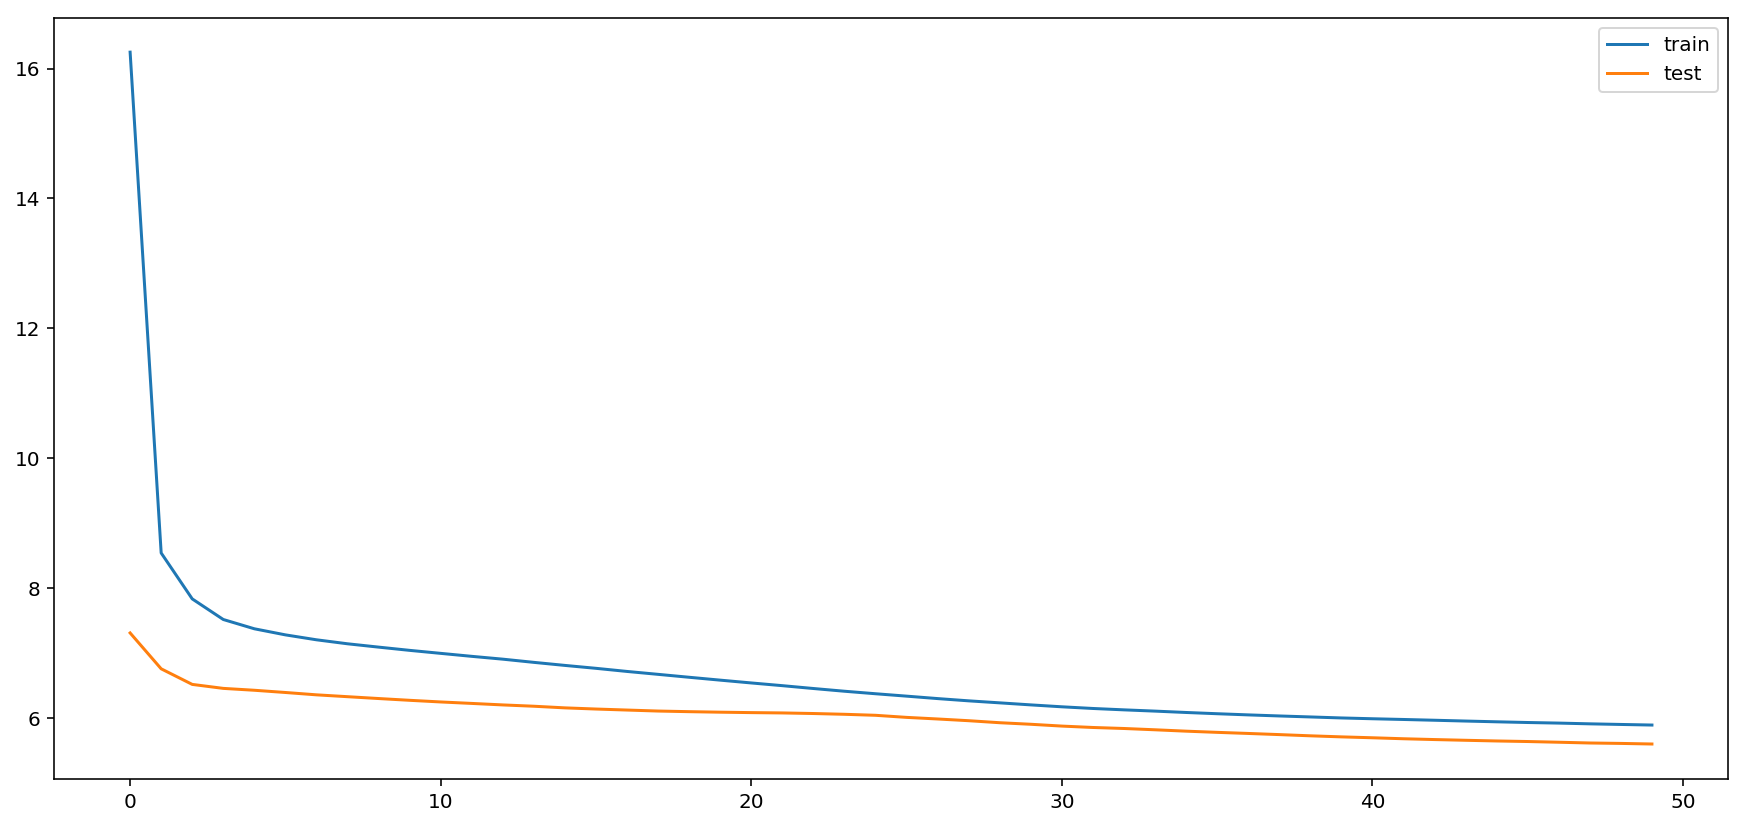

In [21]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [22]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [23]:
# #debugging
# print(test_X[:,0:].shape)
# print(test_X[:,46:].shape)
# print(yhat.shape)
# # print(test_y)

In [24]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, len(dataset.columns):]), axis=1) #got tired of putting column #s manually
# inv_yhat = concatenate((yhat, test_X[:, 8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat) #inverse_transform UN-scales what we transformed earlier above
inv_yhat = inv_yhat[:,0]

In [25]:
# ORIGINAL CODE FOR REFERENCE -- DO NOT TOUCH--# invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat) #inverse_transform UN-scales what we transformed earlier above
# inv_yhat = inv_yhat[:,0]

In [25]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, len(dataset.columns):]), axis=1) #got tired of putting column #s manually
# inv_y = concatenate((test_y, test_X[:, 8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# # calculate RMSE
# With forecasts and actual values in their original scale, we can then calculate an error score for the model. 
# In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.219


In [37]:
#### PREDICTION TIMEXXXXX

In [26]:
# load dataset
dataset_pred = read_csv('ALTEDataPredictCaps.csv', header=0, index_col=0)
dataset_pred.drop(['Region'], axis=1,inplace=True)
# dataset.set_index('TradeDate', inplace=True)
dataset_pred.index = dataset_pred.index.to_datetime()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  """


In [27]:
fix_dt(dataset_pred)

In [28]:
dataset_pred.drop(columns=['HE'], inplace=True)

In [29]:
# dataset.dropna(inplace=True)
values_pred = dataset_pred.values  #dataset.drop("LMP_DELTA", axis = 1).values
#values_y = dataset["LMP_DELTA"].values

In [30]:
# integer encode direction
encoder = LabelEncoder()
colArray = [0]
for i in colArray:
#     print(i)
    values_pred[:,i] = encoder.fit_transform(values_pred[:,i])

In [31]:
# ensure all data is float
values_pred = values_pred.astype('float32')

In [32]:
# normalize features
scaler_pred = MinMaxScaler(feature_range=(0, 1))
scaled_pred = scaler_pred.fit_transform(values_pred)
# # frame as supervised learning
reframed_pred = series_to_supervised(scaled_pred, 1, 1)

In [33]:
# values_y = values_y[1:]
# split into train and test sets
# values_pred = reframed.values
# #n_train_hours = 365 * 24
# length  = round((len(values)*.75)) #.75 is the cutoff point of the training set
pred_X = reframed_pred.values
# train_X = values[:length, :]
# pred_X = values_pred[14:, :]
# train_y = values_y[:length]
# test_y = values_y[length:]
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
pred_X = pred_X.reshape((pred_X.shape[0], 1, pred_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [34]:
# design network -- Original code
model_pred = Sequential()
model_pred.add(LSTM(50, input_shape=(pred_X.shape[1], pred_X.shape[2]))) #50 is the number of nuerons/nodes
model_pred.add(Dense(1)) #this is the output layer. With LSTM 1 output layer is the norm
model_pred.compile(loss='mae', optimizer='adam')
model_pred.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                15000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [35]:
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [36]:
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

In [37]:
# make a prediction
yhat_pred = model_pred.predict(pred_X)
pred_X = pred_X.reshape((pred_X.shape[0], pred_X.shape[2]))

In [38]:
# invert scaling for forecast
inv_yhat_pred = concatenate((yhat_pred, pred_X[:, len(dataset.columns):]), axis=1) #got tired of putting column #s manually
# inv_yhat_pred = concatenate((yhat_pred, pred_X[:, 8:]), axis=1)
inv_yhat_pred = scaler_pred.inverse_transform(inv_yhat_pred) #inverse_transform UN-scales what we transformed earlier above
# inv_yhat_pred = inv_yhat_pred[:,0]

In [39]:
inv_yhat_pred[:,3]

array([ 0.18000008,  0.19999999,  0.19999999,  0.20999993, -0.44      ,
       -0.5199999 , -0.19999999, -1.49      ,  0.47000003,  0.42000002,
       -0.19000003,  0.28999996,  0.37999994,  0.36      ,  0.31999996,
        0.33000004,  0.36      ,  0.25999996,  0.22999997,  0.31999996,
        0.28      , -0.16000004,  0.68      ], dtype=float32)

In [40]:
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 8:]), axis=1) #got tired of putting column #s manually
# # inv_y = concatenate((test_y, test_X[:, len(dataset.columns):]), axis=1) #got tired of putting column #s manually
# # inv_y = concatenate((test_y, test_X[:, 8:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [41]:
pred_X

array([[0.        , 0.05670667, 0.13606912, 0.6543778 , 0.13032736,
        0.5333333 , 0.34881335, 0.28160328, 0.47546014, 0.29618406,
        0.29744768, 0.70000076, 0.        , 0.        , 0.05831534,
        0.76958525, 0.03026559, 0.58      , 0.27966598, 0.21685508,
        0.4202454 , 0.15162992, 0.15794802, 0.70000076],
       [0.        , 0.        , 0.05831534, 0.76958525, 0.03026559,
        0.58      , 0.27966598, 0.21685508, 0.4202454 , 0.15162992,
        0.15794802, 0.70000076, 0.        , 0.01017809, 0.03671707,
        0.7788018 , 0.03335392, 0.5866667 , 0.2886024 , 0.2245632 ,
        0.41717795, 0.05130148, 0.06393766, 0.70000076],
       [0.        , 0.01017809, 0.03671707, 0.7788018 , 0.03335392,
        0.5866667 , 0.2886024 , 0.2245632 , 0.41717795, 0.05130148,
        0.06393766, 0.70000076, 0.        , 0.0214467 , 0.00215983,
        0.7788018 , 0.02594194, 0.5133333 , 0.334896  , 0.22661869,
        0.3834356 , 0.00202179, 0.02678823, 0.70000076],
       [0.   

In [42]:
yhat_pred

array([[-0.01425001],
       [-0.03200625],
       [-0.03981597],
       [-0.04580465],
       [-0.04229191],
       [-0.01131873],
       [ 0.04499811],
       [ 0.10947068],
       [ 0.12751414],
       [ 0.11446545],
       [ 0.12298869],
       [ 0.1125965 ],
       [ 0.09882713],
       [ 0.07965434],
       [ 0.07198235],
       [ 0.06642181],
       [ 0.07770621],
       [ 0.11594453],
       [ 0.12806408],
       [ 0.1228177 ],
       [ 0.09029114],
       [ 0.07049569],
       [ 0.05218603]], dtype=float32)

In [56]:
inv_yhat_pred

array([[ 0.05110319,  0.10982311,  0.82341456,  0.4770115 ,  0.12691641,
         0.13640165,  1.        ],
       [ 0.06952655,  0.        ,  0.849756  ,  0.45402297,  0.0415678 ,
         0.04552317,  1.        ],
       [ 0.08011509,  0.00427091,  0.91609746,  0.37931034,  0.        ,
         0.        ,  1.        ],
       [ 0.07707858,  0.13727891,  0.87999994,  0.5689655 ,  0.01801801,
         0.0144465 ,  1.        ],
       [ 0.05600831,  0.21659553,  0.8478048 ,  0.6321839 ,  0.12991929,
         0.15807152,  1.        ],
       [ 0.04292757,  0.36973763,  0.99999994,  0.8218391 ,  0.3189504 ,
         0.35931468,  1.        ],
       [ 0.01527683,  0.41366684,  0.8878048 ,  0.51724136,  0.5120909 ,
         0.57147646,  1.        ],
       [-0.00538496,  0.41671753,  0.77365845,  0.6264367 ,  0.625731  ,
         0.6999831 ,  1.        ],
       [-0.02345712,  0.5222697 ,  0.78634137,  0.6436781 ,  0.70222855,
         0.7809508 ,  1.        ],
       [-0.03451183,  0.4868

In [58]:
inv_yhat_pred

array([[ 5.11031933e-02,  1.95000000e+01,  1.34000003e+00,
         2.70000041e-01,  1.52020000e+04,  1.50949990e+04,
         1.66000000e+03],
       [ 6.95265457e-02,  1.77000008e+01,  1.60999978e+00,
         2.30000004e-01,  1.46620000e+04,  1.45540000e+04,
         1.66000000e+03],
       [ 8.01150873e-02,  1.77700005e+01,  2.28999972e+00,
         1.00000024e-01,  1.43990000e+04,  1.42830000e+04,
         1.66000000e+03],
       [ 7.70785809e-02,  1.99500008e+01,  1.92000008e+00,
         4.30000007e-01,  1.45130000e+04,  1.43690000e+04,
         1.66000000e+03],
       [ 5.60083054e-02,  2.12500000e+01,  1.58999979e+00,
         5.40000021e-01,  1.52209990e+04,  1.52240000e+04,
         1.66000000e+03],
       [ 4.29275706e-02,  2.37600002e+01,  3.15000010e+00,
         8.70000005e-01,  1.64170000e+04,  1.64220000e+04,
         1.66000000e+03],
       [ 1.52768334e-02,  2.44799995e+01,  2.00000000e+00,
         3.40000004e-01,  1.76390000e+04,  1.76850000e+04,
         1.6600000

In [43]:
inv_yhat_pred

array([[-1.42500130e-02,  2.72399998e+01, -4.69999999e-01,
         1.80000082e-01,  3.19999993e-01, -2.50000030e-01,
        -3.60000038e+00,  7.90000081e-01, -4.30000037e-01,
         1.80640000e+04,  1.79400000e+04,  4.36000000e+03],
       [-3.20062526e-02,  2.75199986e+01, -5.69999993e-01,
         1.99999988e-01,  3.70000005e-01, -2.39999950e-01,
        -2.98999929e+00,  9.40000057e-01, -4.39999968e-01,
         1.76670000e+04,  1.75680000e+04,  4.36000000e+03],
       [-3.98159698e-02,  2.78299980e+01, -7.30000019e-01,
         1.99999988e-01,  2.50000000e-01, -3.50000024e-01,
         1.70000896e-01,  9.80000019e-01, -5.50000012e-01,
         1.74720000e+04,  1.74210000e+04,  4.36000000e+03],
       [-4.58046496e-02,  2.85300007e+01, -7.40000010e-01,
         2.09999934e-01,  1.10000002e+00, -4.69999999e-01,
         2.51999927e+00,  1.84000015e+00, -6.79999948e-01,
         1.74640000e+04,  1.73150000e+04,  4.36000000e+03],
       [-4.22919095e-02,  3.16200008e+01,  3.4000003